In [33]:
import gymnasium as gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt

def get_next_step(x):
  # x will be a numpy array with the contents of the input to the
  # tf.function
  s1,r,d,_, _  = env.step(int(x))
  return s1,r,d,_,_

def get_random_step():
    return env.action_space.sample()

def glorot_init(shape):
    return tf.cast(tf.random.normal(shape=shape, stddev=0.001 / tf.sqrt(shape[0] / 2.), seed=0), dtype=tf.float32)

def generate_vars(net_size):
    weights = dict()
    biases = dict()
    for i in range(0, len(net_size)-1):
        weights['l'+str(i+1)] = tf.Variable(glorot_init([net_size[i], net_size[i+1]]))
        biases['l'+str(i+1)]  = tf.Variable(glorot_init([net_size[i+1]]))
    return weights, biases

def neural_net(x, net_size, weights, biases):
    curr_layer = x
    for j in range(0, len(net_size)-1):
        curr_layer = tf.add(tf.matmul(curr_layer, weights['l'+str(j+1)]), biases['l'+str(j+1)])
        curr_layer = 5*tf.nn.tanh(curr_layer)
    return curr_layer

In [34]:
net_size = [16, 4]
weights, biases = generate_vars(net_size)

env = gym.make('FrozenLake-v1')
num_actions = env.action_space.n
num_states = env.observation_space.n
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-3)
# Set learning parameters
gamma = 0.99
num_episodes = 5000

In [35]:
num_of_steps = []
reward_list = []
for i in range(num_episodes):
    #this is a tricky part - setting the random decay rate
    eps = 0.1*np.exp(-1.15e-6*i)
    #Reset environment an
    # d get first new observation
    s, p = env.reset()
    r_acc = 0
    d = False
    #The Q-Network
    for j in range(1,99):
        # with tf.GradientTape() as g:
        #Choose an action by greedily (with e chance of random action) from the Q-network
        #there are 16 states in this one-hot-vector and we roll the 1 to its proper location
        init_input = tf.roll(tf.constant([1]+(num_states-1)*[0], dtype=tf.float32, shape=(1,num_states)), s, 1)
        #forward pass
        allQ = neural_net(init_input, net_size, weights, biases)
        #using eps for randomness. eps is decaying exponentialy. 
        if tf.random.uniform([1]) < eps:
            #chossing a random action
            a = tf.numpy_function(get_random_step, [], tf.float32)
        else:
            #chossing the proper action
            a = tf.argmax(allQ, 1)[0]
        #Get new state and reward from environment
        s1,reward,d,_, _  = tf.numpy_function(get_next_step, [a], tf.float32)
        #Train our network using target and predicted Q values
        input   = tf.roll(tf.constant([1]+(num_states-1)*[0], dtype=tf.float32, shape=(1,num_states)), s1, 1)
        tmp1    = tf.roll(tf.constant([0] + (num_actions - 1) * [1], dtype=tf.float32), a, 0)
        Q1      = neural_net(input, net_size, weights, biases)
        maxQ1   = tf.reduce_max(Q1)
        tmp2    = tf.roll(tf.concat(([tf.reshape(reward + gamma * maxQ1, (1)), tf.constant((num_actions - 1) * [0], dtype=tf.float32)]), 0), a, 0)
        targetQ = tf.multiply(allQ, tmp1) + tmp2

        with tf.GradientTape() as g:
            curr_Q = neural_net(init_input, net_size, weights, biases)
            loss   = tf.reduce_sum(tf.square(targetQ - curr_Q))
        trainable_variables = [w for w in weights.values()]+[b for b in biases.values()]
        gradients  = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        r_acc += reward
        s = s1
        if d == True:
            break
    num_of_steps.append(j)
    reward_list.append(r_acc)

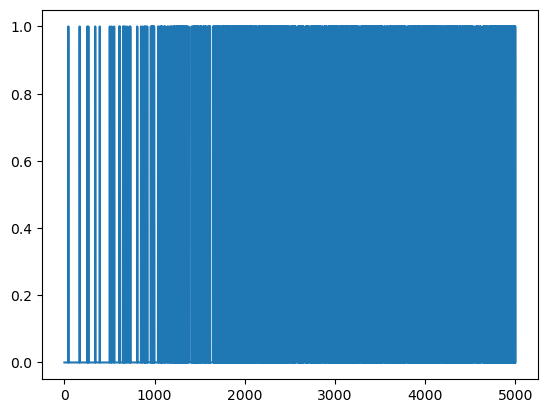

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
plt.plot(range(len(reward_list)), reward_list)
plt.show()

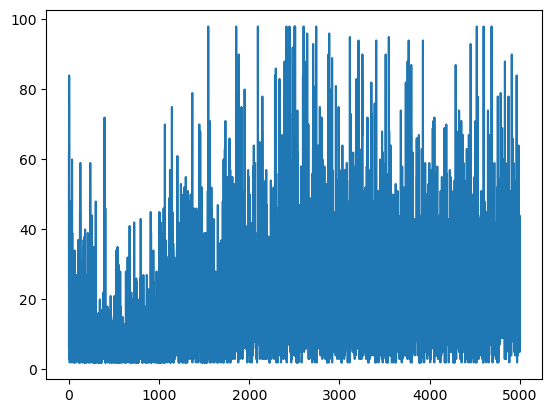

In [37]:
plt.plot(range(len(num_of_steps)), num_of_steps)
plt.show()